# ActBlue basic details

In [69]:
import json
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import os
import requests

In [70]:
%matplotlib inline

plt.style.use('ggplot')

In [71]:
def read_or_save(name, func):
    path = 'pickles/' + name + '.pickle.gz'
    if (os.path.isfile(path)):
        return pd.read_pickle(path)
    else:
        result = func()
        os.makedirs('pickles', exist_ok=True)
        result.to_pickle(path)
        return result

In [72]:
committee_id = "C00401224"

### Connect to the PostgreSQL database

In [73]:
with open("config.json") as f:
    conf = json.load(f)
conn = psycopg2.connect(
    dbname=conf['dbname'],
    user=conf['user'],
    host=conf['host'],
    password=conf['password']
)

### How many reports are in the database?

In [74]:
read_or_save(
    'filings_count',
    lambda: pd.read_sql("""
    SELECT count(*)
    FROM fec_filings;
    """, con=conn)
)

,count
0,289547


### Which ActBlue reports do we have?

In [83]:
actblue_summaries = read_or_save(
    'actblue_summaries',
    lambda: pd.read_sql("""
    SELECT *
    FROM fec_pac_summaries
    JOIN fec_amended_filings USING (filing_id)
    WHERE filer_committee_id_number = '""" + committee_id + """';
    """, con=conn, parse_dates={
        'coverage_from_date': '%Y-%m-%d',
        'coverage_through_date': '%Y-%m-%d'
    })
)

actblue_summaries.sort_values(by='coverage_through_date', ascending=False)
actblue_summaries[[
    'filing_id',
    'form_type',
    'committee_name',
    'coverage_from_date',
    'coverage_through_date',
    'report_code',
    'col_a_total_contributions'
]]

,filing_id,form_type,committee_name,coverage_from_date,coverage_through_date,report_code,col_a_total_contributions
0,903093,F3XN,ActBlue,2013-12-01,2013-12-31,YE,8.291621e+06
1,907993,F3XN,ActBlue,2014-01-01,2014-01-31,M2,5.899102e+06
2,912211,F3XN,ActBlue,2014-02-01,2014-02-28,M3,8.488177e+06
3,921401,F3XN,ActBlue,2014-03-01,2014-03-31,M4,1.532761e+07
4,926005,F3XN,ActBlue,2014-04-01,2014-04-30,M5,9.572387e+06
5,932286,F3XN,ActBlue,2014-05-01,2014-05-31,M6,1.110815e+07
6,942637,F3XN,ActBlue,2014-06-01,2014-06-30,M7,1.741317e+07
7,946367,F3XN,ActBlue,2014-07-01,2014-07-31,M8,1.716504e+07
8,952738,F3XN,ActBlue,2014-08-01,2014-08-31,M9,1.982896e+07
9,961472,F3XN,ActBlue,2014-09-01,2014-09-30,M10,3.294525e+07


### How have contributions changed over time?

Text(0.5,1,'Total contributions by reporting period')

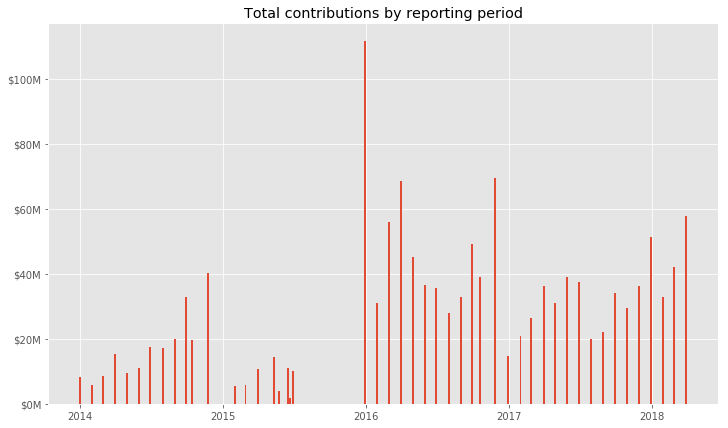

In [28]:
contribs_over_time = actblue_summaries[['coverage_through_date','col_a_total_contributions']]

# https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html
contribs_over_time.set_index('coverage_through_date',inplace=True)

fig, ax = plt.subplots(figsize=(12,7))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '$%1.fM' % (x*1e-6)))

ax.bar(contribs_over_time.index, contribs_over_time['col_a_total_contributions'], width=5)

ax.set_title('Total contributions by reporting period')

In [78]:
def get_reports(committee_id):
    base = "https://api.open.fec.gov/v1/"
    url = base + "committee/" + committee_id + "/reports/?api_key=" + conf['fec_key'] + "&is_amended=False&per_page=100"

    return pd.DataFrame(requests.get(url).json()['results'])

actblue_api_summaries = read_or_save('fec_actblue_reports', lambda: get_reports(committee_id))
pd.to_numeric(actblue_api_summaries['calendar_ytd'])
actblue_api_summaries = actblue_api_summaries[actblue_api_summaries['calendar_ytd'] > 2013]
actblue_api_summaries[['file_number','calendar_ytd']]

,file_number,calendar_ytd
0,1225971,2018
1,1215697,2018
2,1224404,2018
3,1224416,2017
4,1219434,2017
5,1219420,2017
6,1218757,2017
7,1217404,2017
8,1217370,2017
9,1217173,2017


In [84]:
pd.DataFrame(pd.concat([actblue_api_summaries['file_number'],
                        actblue_summaries['filing_id']]).drop_duplicates(keep=False))

,0
16,1190211
36,989398
0,903093
30,1166544


### Questions to answer
> - How many Democratic campaigns are reporting using ActBlue? Does it essentially have a monopoly on the D side?
> - What percent of Democratic candidate dollars so far this cycle have come through ActBlue?
> - Are Republican groups reporting any small donor data that we could analyze in a valid way, or is that just impossible?
> - Is this fueling primary fights?
